In [87]:
%load_ext autoreload
%autoreload 2


## classic pydata stack
import os 
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline 

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (30,10)
VERY_SMALL_SIZE = 4
SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys

import vanilla_NN as NN

sys.path.append('..')
from pipeline import *
from models import *


In [47]:
pipe = AA0066_Pipeline(num_blocks=1)

dataset = PolymerDataset(data_paths=["AA00400AA.npy","AA66466AA.npy"],pipeline=pipe)

Processing AA66466AA.npy: 100%|██████████| 14185/14185 [02:40<00:00, 88.26it/s] 


In [51]:
np.save(arr=dataset.labels.numpy(),file="backbone_bulky4_labels")

In [4]:
def kfold_cv_iter(y: np.ndarray, tx: np.ndarray, k: int = 5, seed: float = 1):
    """K-fold cross validation. Split data into k parts and iterate through the folds
    Args:
        y (np.ndarray): Label data
        tx (np.ndarray): Features data
        k (int, optional): Number of folds. Defaults to 5.
        seed (float, optional): Seed for randomization. Defaults to 1.
    Yields:
        Generator: (x_train, y_train, x_test, y_test)
    """
    num_row = y.shape[0]
    fold_size = int(num_row / k)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = list(set(range(num_row)) - set(test_indices))
        yield tx[train_indices], y[train_indices], tx[test_indices], y[test_indices]


## Random forest with removing a feature

In [107]:
names=["mean", "median", "std", "min", "max", "len", "count_extremums", "max_slope", "min_slope"]
y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

for i in range(9):
    tx = np.load("backbone_bulky4_data_1.npy",allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))
    mask = np.zeros((9), dtype=bool)
    mask[i] = True

    tx =tx[:,np.logical_not(mask)]


    iter = kfold_cv_iter(y=y,tx=tx,k=3,seed=2)
    accuracies = []
    for X_train, Y_train, X_test, Y_test in iter:
        classifier = RandomForestClassifier(random_state=89,n_estimators = 100 )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)

    print(f"Removing feature {names[i]}: ",np.array(accuracies).mean())


Removing feature mean:  0.9498006843757717
Removing feature median:  0.9479309979892051
Removing feature std:  0.9354076269093731
Removing feature min:  0.935301795604473
Removing feature max:  0.9464846368222387
Removing feature len:  0.9461318658059054
Removing feature count_extremums:  0.9495890217659717
Removing feature max_slope:  0.9508237203231383
Removing feature min_slope:  0.9491656965463718


## Random forest with different num_blocks

In [6]:
feature_importances = []
y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

for i in range(1,11):
    path = f"backbone_bulky4_data_{i}.npy"
    tx = np.load(path,allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))

    iter = kfold_cv_iter(y=y,tx=tx,k=3,seed=2)
    accuracies = []
    importances = []
    for X_train, Y_train, X_test, Y_test in iter:
        classifier = RandomForestClassifier(random_state=89,n_estimators = 100 )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)
        importances.append(classifier.feature_importances_)

    print(f"num_blocks={i}",": ",np.array(accuracies).mean())
    feature_importances.append(np.array(importances).mean())

num_blocks=1 :  0.9506120577133382
num_blocks=2 :  0.9566444420926378
num_blocks=3 :  0.9583377429710375
num_blocks=4 :  0.9586199597841042
num_blocks=5 :  0.9594313331216707
num_blocks=6 :  0.9579496948530708
num_blocks=7 :  0.9571735986171376
num_blocks=8 :  0.9562916710763044
num_blocks=9 :  0.9564680565844711
num_blocks=10 :  0.9506120577133382


In [82]:
def train_random_forest(x,y, k=5, n_estimators = 100):
    accuracies = []
    importances = []

    iter = kfold_cv_iter(y=y,tx=tx,k=k,seed=2)
    for X_train, Y_train, X_test, Y_test in iter:
        classifier = RandomForestClassifier(random_state=89,n_estimators = n_estimators )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)
        importances.append(classifier.feature_importances_)

    accuracies = np.array(accuracies)
    importances = np.array(importances)
    
    return accuracies, importances, classifier

In [34]:
path = f"backbone_bulky4_data_{5}.npy"
y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)
tx = np.load(path,allow_pickle=True)
tx = tx.reshape((tx.shape[0],-1))
forest5 = train_random_forest(tx,y)

print(f"Accuracy: {forest5[0].mean()}")

Accuracy: 0.9592167930852001


In [90]:
def plot_feature_importances(num_blocks,save=True):

    path = f"backbone_bulky4_data_{num_blocks}.npy"
    y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)
    tx = np.load(path,allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))
    forest = train_random_forest(x=tx,y=y)


    features = forest[1].mean(axis=0)
    names=["mean", "median", "std", "min", "max", "len", "count_extremums", "max_slope", "min_slope"]

    df = pd.DataFrame()
    df['names'] = pd.Series(names*num_blocks)
    df['features'] = pd.Series(features)
    df['block_number'] = pd.Series([i  for i in range(1,num_blocks+1) for j in range(len(names))]) 

    f,a = plt.subplots(1,1,figsize=(30,15))
    g= sns.barplot(x='names', y='features', data=df, hue='block_number')
    g.set_title(f"Random Forest Features Importances (num_blocks={num_blocks})")
    g.set_xlabel("Feature names")
    g.set_ylabel("Feature importance")

    if save:
        plt.savefig(f"random_forest_feature_importances_{num_blocks}.png", dpi=300)

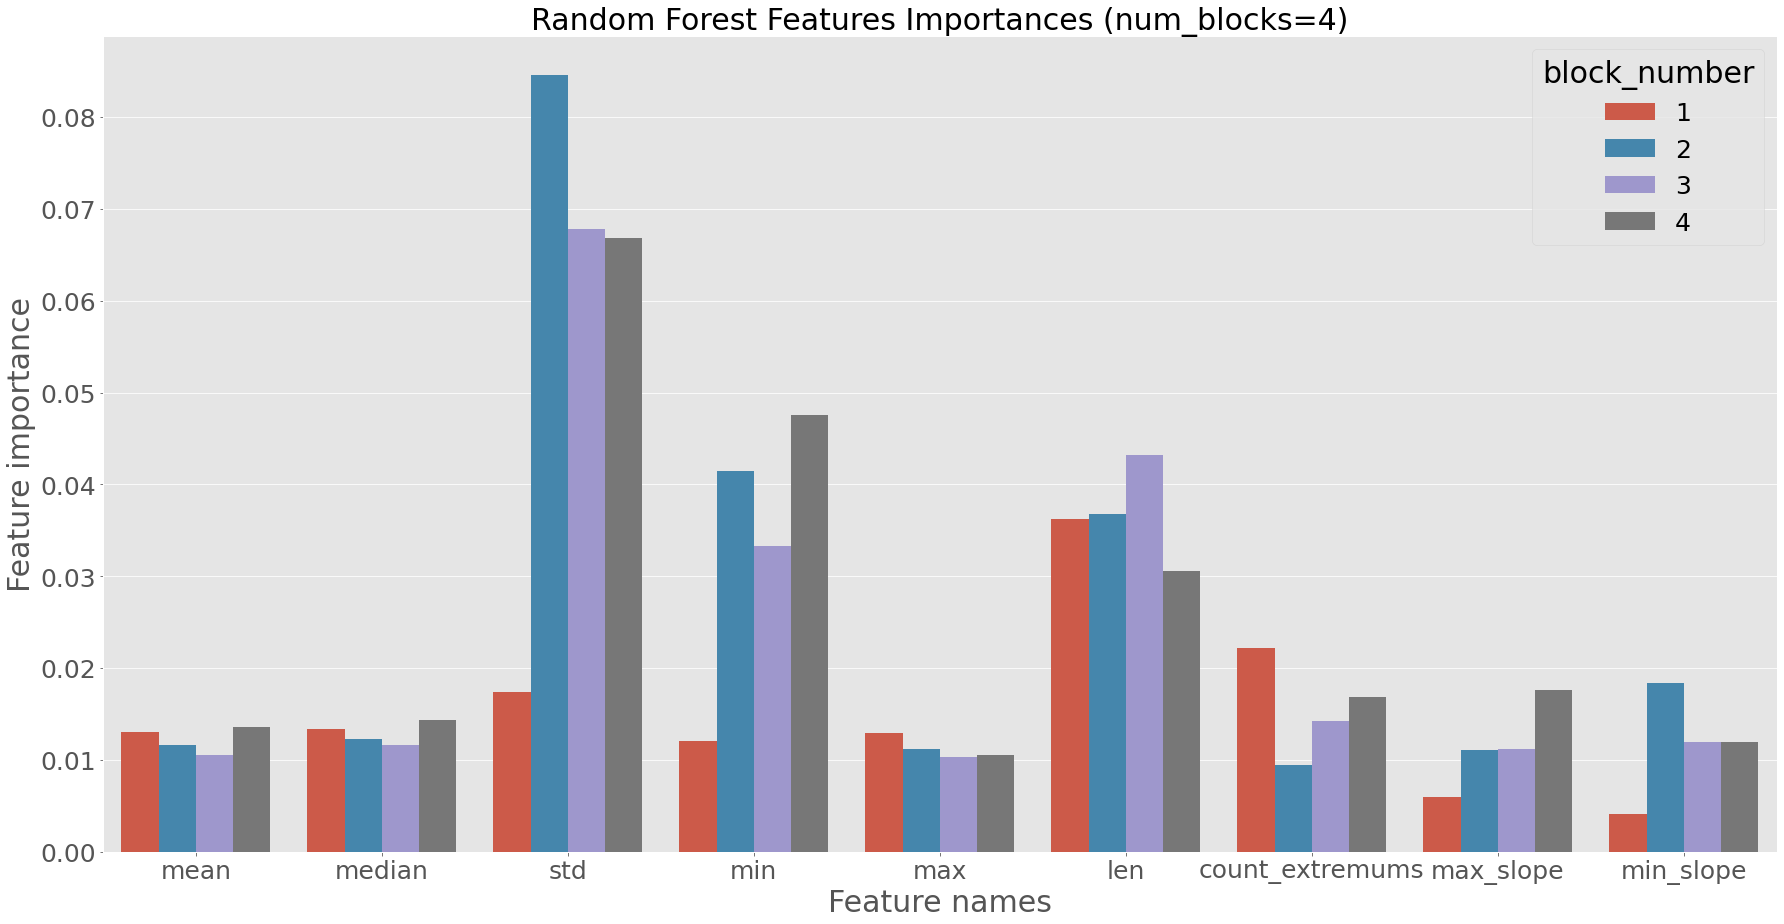

In [95]:
plot_feature_importances(num_blocks=4,save=True)

<AxesSubplot:xlabel='names', ylabel='features'>

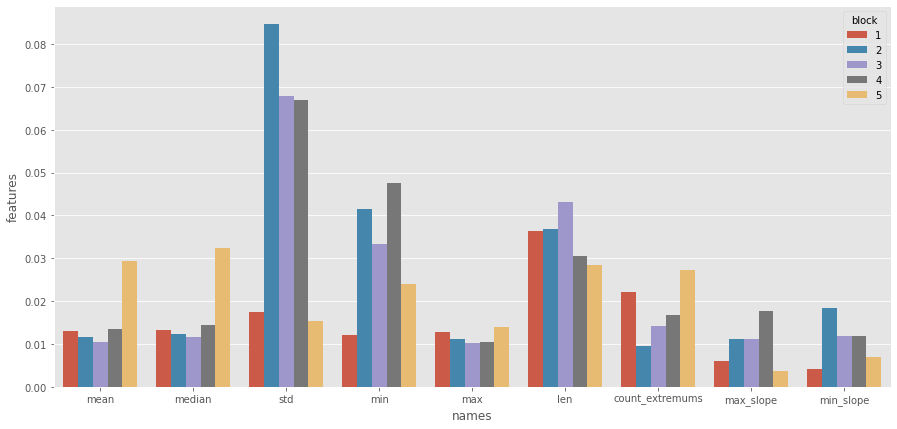

In [76]:
sns.barplot(x='names', y='features', data=df, hue='block')

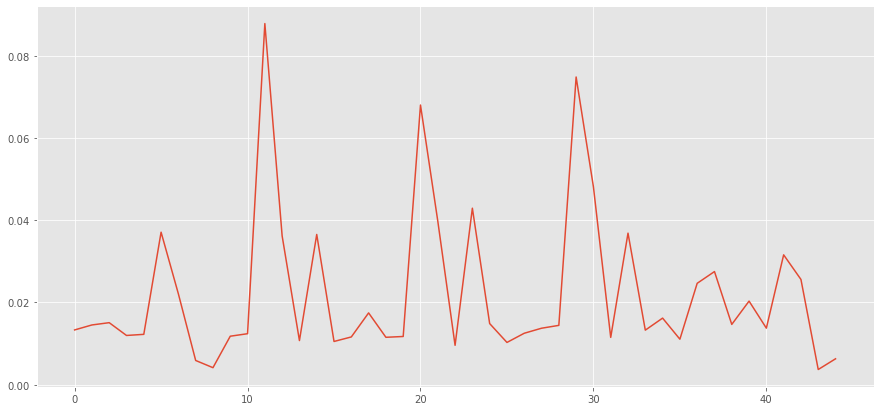

In [22]:
plt.plot(features)

In [23]:
path = f"backbone_bulky4_data_{1}.npy"
tx = np.load(path,allow_pickle=True)
tx = tx.reshape((tx.shape[0],-1))
iter = kfold_cv_iter(y=y,tx=tx,k=5,seed=2)
accuracies = []
importances = []
for X_train, Y_train, X_test, Y_test in iter:
    classifier = RandomForestClassifier(random_state=89,n_estimators = 100 )
    classifier.fit(X_train, Y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    accuracies.append(accuracy)
    importances.append(classifier.feature_importances_)

np.array(accuracies).mean()
features = np.array(importances).mean(axis=0)

In [25]:

np.array(accuracies).mean()

0.9514200035279592

ValueError: x and y must be the same size

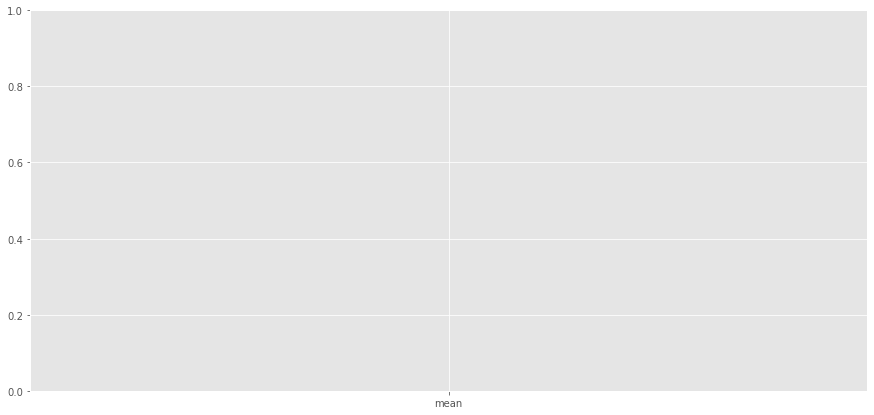

In [29]:
names=["mean", "median", "std", "min", "max", "len", "count_extremums", "max_slope", "min_slope"]
plt.scatter(x=names,y=features)

### Gradient boosting classifier with removing a feature

In [105]:
from sklearn.ensemble import GradientBoostingClassifier

names=["mean", "median", "std", "min", "max", "len", "count_extremums", "max_slope", "min_slope"]
from sklearn.metrics import accuracy_score

for i in range(9):
    tx = np.load("backbone_bulky4_data_1.npy",allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))
    mask = np.zeros((9), dtype=bool)
    mask[i] = True

    tx =tx[:,np.logical_not(mask)]


    iter = kfold_cv_iter(y=y,tx=tx,k=3,seed=2)
    accuracies = []
    for X_train, Y_train, X_test, Y_test in iter:
        classifier =GradientBoostingClassifier(random_state=89,n_estimators = 100 )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)

    print(names[i],": ",np.array(accuracies).mean())


mean :  0.9448266130454721
median :  0.9422866617278723
std :  0.9335379405228067
min :  0.9263766888912407
max :  0.9379475782269728
len :  0.9400289272233393
count_extremums :  0.9446855046389389
max_slope :  0.9445443962324056
min_slope :  0.9424630472360391


 ## Gradient boosting classifier with different num_blocks

In [106]:
for i in range(1,11):
    path = f"backbone_bulky4_data_{i}.npy"
    tx = np.load(path,allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))

    iter = kfold_cv_iter(y=y,tx=tx,k=3,seed=2)
    accuracies = []
    for X_train, Y_train, X_test, Y_test in iter:
        classifier = GradientBoostingClassifier(random_state=89,n_estimators = 100 )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)

    print(f"num_blocks={i}",": ",np.array(accuracies).mean())

num_blocks=1 :  0.944050516809539
num_blocks=2 :  0.9525522983031713
num_blocks=3 :  0.9549864183158712
num_blocks=4 :  0.9551275267224044
num_blocks=5 :  0.9546336472995378
num_blocks=6 :  0.9557625145518044
num_blocks=7 :  0.9553391893322045
num_blocks=8 :  0.9553391893322045
num_blocks=9 :  0.9547747557060712
num_blocks=10 :  0.944050516809539


In [ ]:
class PaddedDataset():

    def __init__(self, data_paths,seed=10):
        self.process(data_paths,seed)


    def process(self,data_paths,seed):

        raw_data = [np.load(data_path, allow_pickle=True) for data_path in data_paths]
        labels = [0,1]

    ## balance the dataset by removing signals that are too short or too long
    ## first we build the dataframe to know the lengths of the time series

        len_series = []

        for data in raw_data:
            lengths= []
            for row in data:
                ## length of time series
                lengths.append(row.shape[0])

            len_series.append(pd.Series(lengths))

        ## enforces that the first dataset is the smaller one in total size
        ## such that we can apply our balancing operations generally
        if len(len_series[0]) > len(len_series[1]):
            len_series.reverse()
            raw_data.reverse()
            labels.reverse()

        ## filter the dataset and remove signals that are:
        ## too short i.e. < len_series[0].quantile(0.1)
        ## too long i.e. > len_series[0].quantile(0.9)
        for i in range(2):
            mask = (len_series[i] > max(len_series[0].quantile(0.1),num_blocks)) & (len_series[i] < len_series[0].quantile(0.5))
            raw_data[i] = raw_data[i][mask]

        ## most likely, one dataset is still bigger than the other one
        ## therefore, we randomly sample data from the bigger dataset to create a new dataset of the same size as the small one 
        np.random.seed(seed=seed)

        # making sure the smallest dataset is the first one
        if len(raw_data[0]) > len(raw_data[1]):
            raw_data.reverse()
            labels.reverse()

        # randomly sampling and making a balanced dataset
        raw_data[1]  = np.random.permutation(raw_data[1])[:len(raw_data[0])]
        data=[]
        data_labels=[]
        
        max_length = max(len_series[0].max(), len_series[1].max())
        print("Max length",max_length)

        ## using our Input class to build the entire dataset and extracting features from each row
        for index, raw_data in enumerate(raw_data):
            for raw_series in raw_data:
                padded_series = self.pad(raw_series,max_length)
                data.append(padded_series)
                data_labels.append(labels[index])
        data = np.array(data)

        #normalizing features
        data = (data - data.mean(axis=0)) / data.std(axis=0)
        data_labels = np.array(data_labels)

        self.data = data
        self.labels = data_labels

        return self

    
    def pad(self,raw_series, max_length):

        l = max_length - raw_series.shape[0]
        x=raw_series[:,0]
        y= raw_series[:,1]

        if l > 0:
            res1 = np.concatenate((x, np.linspace(start= x[-1] + 0.01, stop= x[-1] + l*0.01 , num=l)),axis=None)
            res2 = np.concatenate((y, np.zeros(l)),axis=None)

        res = np.vstack((res1,res2)).T

        return res
        

In [ ]:
dataset = PaddedDataset(data_paths=["AA00400AA.npy","AA66466AA.npy"])

MemoryError: 

In [ ]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = dataset.data, dataset.labels
X_train, X_test, y_train, y_test = train_test_split(X, y)
classifier = TimeSeriesForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

ValueError: If passed as a np.array, X must be a 3-dimensional array, but found shape: (21243, 27)

In [ ]:
dataset.data[1]

array([ 0.17944997, -0.20482437,  0.67186573, -0.00658525,  0.94489608,
       -0.81025791, -0.73619943,  1.31484999, -0.43366814, -0.71692991,
       -0.57235341, -0.45231736, -0.82291628, -0.43769871, -0.81025791,
       -0.89015383,  1.00854561, -1.42100356, -0.48263948, -1.11383077,
        0.41667791, -0.81664598,  0.96985427, -0.81025791, -0.71873826,
        1.37042307, -0.68925605])